# Malaria detection with cell images - data exploration

This data was originally made available by NIH [here](https://ceb.nlm.nih.gov/repositories/malaria-datasets/). It was posted on Kaggle by user Arunava at [iarunava/cell-images-for-detecting-malaria](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria).

Relevant excepts from the NIH website:

> This page hosts a repository of segmented cells from the thin blood smear slide images from the Malaria Screener research activity.

> Giemsa-stained thin blood smear slides from 150 P. falciparum-infected and 50 healthy patients were collected and photographed at Chittagong Medical College Hospital, Bangladesh.

> The images were manually annotated by an expert slide reader at the Mahidol-Oxford Tropical Medicine Research Unit in Bangkok, Thailand. 

> We applied a level-set based algorithm to detect and segment the red blood cells. The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.

> The CSV file for the parasitized class contains 151 patient-ID entries. The slide images for the parasitized patient-ID “C47P8thinOriginal” are read from two different microscope models (Olympus and Motif). The CSV file for the uninfected class contains 201 entries since the normal cells from the infected patients’ slides also make it to the normal cell category (151+50 = 201).

## Load and inspect data

In [1]:
import random
import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
import numpy as np
from skimage.io import imread

In [2]:
data_dir = Path('data', 'cell_images')
positive_dir = data_dir / 'Parasitized'
negative_dir = data_dir / 'Uninfected'

In [3]:
positive_paths = sorted(positive_dir.glob('*.png'), key = lambda p: p.name)
negative_paths = sorted(negative_dir.glob('*.png'), key = lambda p: p.name)

In [4]:
len(positive_paths), len(negative_paths)

(13779, 13779)

### Sample images

In [7]:
def show_images(images, size=3):
    figsize = (size * len(images), size)
    _, ax = plt.subplots(1, len(images), squeeze=False, figsize=figsize)
    for i, image in enumerate(images):
        ax[0, i].imshow(image)

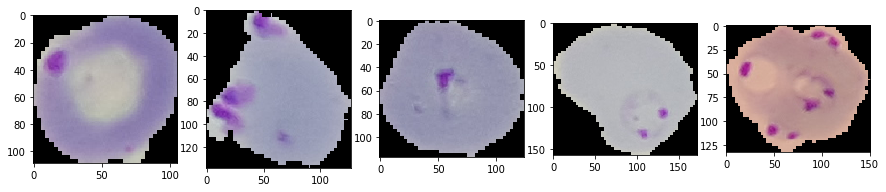

In [8]:
show_images([imread(positive_paths[i]) for i in [8904, 6352, 8837, 6084, 8226]])

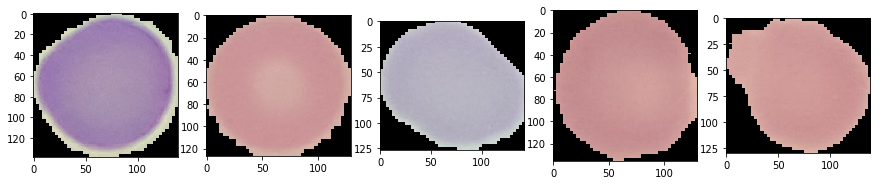

In [9]:
show_images([imread(negative_paths[i]) for i in [3692, 1639, 7509, 11191, 10433]])

### Load metadata into a DataFrame

The filenames are encoded as `<patient>_<slide>_<cell>.png`. Extract this information so we can properly separate the training and test set.

In [10]:
def extract_metadata(path, infected):
    name_match = re.match(r'^(.*)_IMG_(.*)_cell_(.*)\.png$', path.name)
    (patient, slide, cell) = name_match.groups()
    return {
        'infected': infected,
        'patient': patient,
        'slide': slide,
        'cell': slide + '_' + cell,
        'path': path,
    }

In [11]:
labeled_metadata_dicts = (
    [extract_metadata(p, True) for p in positive_paths] +
    [extract_metadata(p, False) for p in negative_paths])

In [12]:
labeled_metadata = pd.DataFrame.from_records(
    labeled_metadata_dicts,
    columns=labeled_metadata_dicts[0].keys(), # Preserve order
)

In [13]:
labeled_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27558 entries, 0 to 27557
Data columns (total 5 columns):
infected    27558 non-null bool
patient     27558 non-null object
slide       27558 non-null object
cell        27558 non-null object
path        27558 non-null object
dtypes: bool(1), object(4)
memory usage: 888.2+ KB


In [14]:
labeled_metadata.head(5)

,infected,patient,slide,cell,path
0,True,C100P61ThinF,20150918_144104,20150918_144104_162,data/cell_images/Parasitized/C100P61ThinF_IMG_...
1,True,C100P61ThinF,20150918_144104,20150918_144104_163,data/cell_images/Parasitized/C100P61ThinF_IMG_...
2,True,C100P61ThinF,20150918_144104,20150918_144104_164,data/cell_images/Parasitized/C100P61ThinF_IMG_...
3,True,C100P61ThinF,20150918_144104,20150918_144104_165,data/cell_images/Parasitized/C100P61ThinF_IMG_...
4,True,C100P61ThinF,20150918_144104,20150918_144104_166,data/cell_images/Parasitized/C100P61ThinF_IMG_...


In [15]:
labeled_metadata.tail(5)

,infected,patient,slide,cell,path
27553,False,C99P60ThinF,20150918_142128,20150918_142128_47,data/cell_images/Uninfected/C99P60ThinF_IMG_20...
27554,False,C99P60ThinF,20150918_142128,20150918_142128_52,data/cell_images/Uninfected/C99P60ThinF_IMG_20...
27555,False,C99P60ThinF,20150918_142128,20150918_142128_53,data/cell_images/Uninfected/C99P60ThinF_IMG_20...
27556,False,C99P60ThinF,20150918_142128,20150918_142128_55,data/cell_images/Uninfected/C99P60ThinF_IMG_20...
27557,False,C99P60ThinF,20150918_142128,20150918_142128_56,data/cell_images/Uninfected/C99P60ThinF_IMG_20...


In [16]:
labeled_metadata['infected'].value_counts()

True     13779
False    13779
Name: infected, dtype: int64

### Investigate grouping

Multiple cells are taken from a single slide, and multiple slides are taken from a single patient. We should keep all cells from a single patient in either the training or test set. Check assumptions and collect some basic distributions to make sure this is feasible.

In [17]:
# Check that the cell IDs are unique
assert labeled_metadata['cell'].nunique() == labeled_metadata['cell'].count()

In [18]:
# Check that all slides belong to a unique patient
assert labeled_metadata.groupby('slide')['patient'].nunique().max() == 1

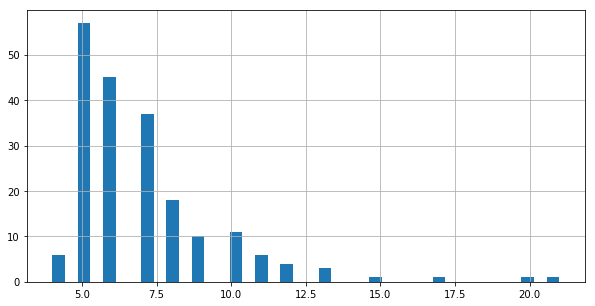

In [19]:
# Slides per patient
labeled_metadata.groupby('patient')['slide'].nunique().hist(bins=40, figsize=(10, 5))

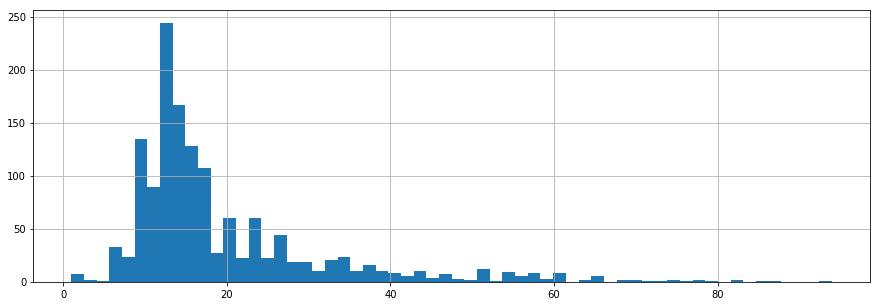

In [20]:
# Cells per slide
labeled_metadata.groupby('slide')['cell'].nunique().hist(bins=60, figsize=(15, 5))

## Test set

Select a random set of patients to split into the test set. This will naturally group the slides as well, and there are enough patients that we shouldn't have to worry about stratifying positive and negative samples.

In [21]:
from sklearn.model_selection import GroupShuffleSplit

In [22]:
def train_test_split_by_patient(data, **kwargs):
    split = GroupShuffleSplit(n_splits=1, **kwargs)
    train_indices, test_indices = next(split.split(data, groups=data['patient']))
    train_set = data.loc[train_indices].reset_index(drop=True)
    test_set = data.loc[test_indices].reset_index(drop=True)
    return train_set, test_set 

In [23]:
labeled_train_meta, labeled_test_meta = train_test_split_by_patient(
    labeled_metadata, random_state=42, test_size=0.2)

In [24]:
len(labeled_train_meta), len(labeled_test_meta)

(21807, 5751)

In [25]:
# Double-check that patients and slides were properly segregated
assert len(set(labeled_train_meta['patient']) & set(labeled_test_meta['patient'])) == 0
assert len(set(labeled_train_meta['slide']) & set(labeled_test_meta['slide'])) == 0

In [26]:
# Make sure the positive and negative samples are still balanced
labeled_train_meta['infected'].value_counts()

False    10978
True     10829
Name: infected, dtype: int64

In [27]:
# Pre-shuffle so we don't have to keep doing it
shuffle_indices = np.random.RandomState(42).permutation(len(labeled_train_meta))
labeled_train_meta = labeled_train_meta.loc[shuffle_indices].reset_index(drop=True)

In [28]:
labeled_train_meta.head(5)

,infected,patient,slide,cell,path
0,True,C140P101ThinF,20151005_211735,20151005_211735_149,data/cell_images/Parasitized/C140P101ThinF_IMG...
1,True,C133P94ThinF,20151004_155912,20151004_155912_10,data/cell_images/Parasitized/C133P94ThinF_IMG_...
2,False,C229ThinF,20151112_144652,20151112_144652_191,data/cell_images/Uninfected/C229ThinF_IMG_2015...
3,True,C136P97ThinF,20151005_142627,20151005_142627_11,data/cell_images/Parasitized/C136P97ThinF_IMG_...
4,True,C97P58ThinF,20150917_152225,20150917_152225_28,data/cell_images/Parasitized/C97P58ThinF_IMG_2...


## Script

Relevant parts of this notebook have been extracted to [load_malaria.py](./load_malaria.py) for use in other notebooks.